In [184]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [185]:
def load_credit_data():
     # Fetch german credit dataset 
     statlog_german_credit_data = fetch_ucirepo(id=144) 
     X = statlog_german_credit_data.data.features 
     y = statlog_german_credit_data.data.targets 

     # Rename columns for clarity
     X.columns = ['account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 
          'savings', 'employment_since', 'installment_rate', 'sex', 'guarantors', 
          'residence_since', 'property', 'age', 'other_plans', 'housing', 
          'num_credits', 'job', 'num_people_maintenance', 'telephone', 'foreign_worker']

     # Rename and regroup categories for readability
     X['account_status'] = X['account_status'].replace({
          'A11': 'overdrawn',
          'A12': 'stable balance',
          'A13': 'stable balance',
          'A14': 'no account'
     })
     X['credit_history'] = X['credit_history'].replace({
          'A30': 'good',
          'A31': 'good',
          'A33': 'bad',
          'A34': 'bad',
          'A32': 'being repaid'
     })
     X['purpose'] = X['purpose'].replace({
          'A40': 'car',
          'A41': 'car',
          'A42': 'domestic equipment',
          'A43': 'domestic equipment',
          'A44': 'domestic equipment',
          'A45': 'others',
          'A46': 'education',
          'A48': 'education',
          'A49': 'business',
          'A410': 'others'
     })
     X['savings'] = X['savings'].replace({
          'A61': 'little',
          'A62': 'moderate',
          'A63': 'moderate',
          'A64': 'rich',
          'A65': 'NA'
     })
     X['employment_since'] = X['employment_since'].replace({
          'A71': 'unemployed',
          'A72': 'recent position',
          'A73': 'recent position',
          'A74': 'long-term position',
          'A75': 'long-term position'
     })
     X['sex'] = X['sex'].replace({
          'A91': 'male',
          'A93': 'male',
          'A94': 'male',
          'A92': 'female',
          'A95': 'female'
     })
     X['housing'] = X['housing'].replace({
          'A151': 'rent',
          'A152': 'own',
          'A153': 'for free'
     })
     X['job'] = X['job'].replace({
          'A171': 'unskilled',
          'A172': 'unskilled',
          'A173': 'skilled',
          'A174': 'skilled'
     })

     # Drop unnecessary attributes
     X = X.drop(['installment_rate', 'residence_since', 'property', 'other_plans', 'telephone', 'foreign_worker', 'guarantors'], axis=1)

     # Map target labels (1 = Good, 2 = Bad) -> (1 = Good, 0 = Bad)
     y = y.replace({1: 1, 2: 0})
     return X, y

In [186]:
X, y = load_credit_data()

C:\Users\lujul\AppData\Local\Temp\ipykernel_31476\2741382294.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['account_status'] = X['account_status'].replace({
C:\Users\lujul\AppData\Local\Temp\ipykernel_31476\2741382294.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['credit_history'] = X['credit_history'].replace({
C:\Users\lujul\AppData\Local\Temp\ipykernel_31476\2741382294.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [187]:
def get_train_test_data(X, y):
    # Transform continuous variables into categorical
    duration_cat = pd.cut(X['duration'], bins=[0, 12, 24, 36, np.inf], labels=['0-12', '13-24', '25-36', '>36']).astype(str)
    X.insert(1, 'duration_cat', duration_cat)
    age_cat = pd.cut(X['age'], bins=[0, 25, 30, 35, 40, 50, np.inf], labels=['0-25', '26-30', '31-35', '36-40', '41-50', '>50']).astype(str)
    X.insert(9, 'age_group', age_cat)
    X = X.drop(['duration', 'age'], axis=1)

    # Ordinal variables encoding
    X['account_status'] = X['account_status'].map({'overdrawn': 1, 'no account': 2, 'stable balance': 3})
    X['credit_history'] = X['credit_history'].map({'bad': 1, 'being repaid': 2, 'good': 3})
    X['savings'] = X['savings'].map({'NA': 1, 'little':2, 'moderate': 3, 'rich': 4})
    X['employment_since'] = X['employment_since'].map({'unemployed': 1, 'recent position': 2, 'long-term position': 3})
    X['job'] = X['job'].map({'unskilled': 1, 'skilled': 2})
    X['duration_cat'] = X['duration_cat'].map({'0-12': 1, '13-24': 2, '25-36': 3, '>36': 4}).astype(int)
    X['age_group'] = X['age_group'].map({'0-25': 1, '26-30': 2, '31-35': 3, '36-40': 4, '41-50': 5, '>50': 6}).astype(int)
    # Binary Encoding for the Sex variable
    label=LabelEncoder()
    X['sex']=label.fit_transform(X['sex'])
    # One-Hot Encoding for non-ordinal variables
    X = pd.get_dummies(X, columns=['purpose', 'housing'], drop_first=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    scaler=MinMaxScaler()
    X_train['credit_amount']=scaler.fit_transform(X_train[['credit_amount']])
    X_test['credit_amount']=scaler.fit_transform(X_test[['credit_amount']])
    return X_train, X_test, y_train, y_test

In [188]:
X_train, X_test, y_train, y_test = get_train_test_data(X, y)

### Baseline models

In [189]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

C:\Users\lujul\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [190]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [191]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

C:\Users\lujul\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

In [215]:
dt = LogisticRegression(random_state=42)
dt.fit(X_train, y_train)

C:\Users\lujul\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

### Model performance

In [192]:
def get_model_performance(y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    cost_matrix = np.array([[0, 5],  
                            [1, 0]])
    cost = np.sum(conf_matrix * cost_matrix)
    
    preds = probs[:, 1]
    fpr, tpr, _ = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, conf_matrix, cost, fpr, tpr, roc_auc

In [193]:
def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, conf_matrix, cost, fpr, tpr, roc_auc = get_model_performance(y_true, y_pred, probs)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Total Cost of Misclassification:", cost)
    
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

Accuracy: 0.765
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.52      0.58        61
           1       0.81      0.87      0.84       139

    accuracy                           0.77       200
   macro avg       0.72      0.70      0.71       200
weighted avg       0.76      0.77      0.76       200

Total Cost of Misclassification: 163


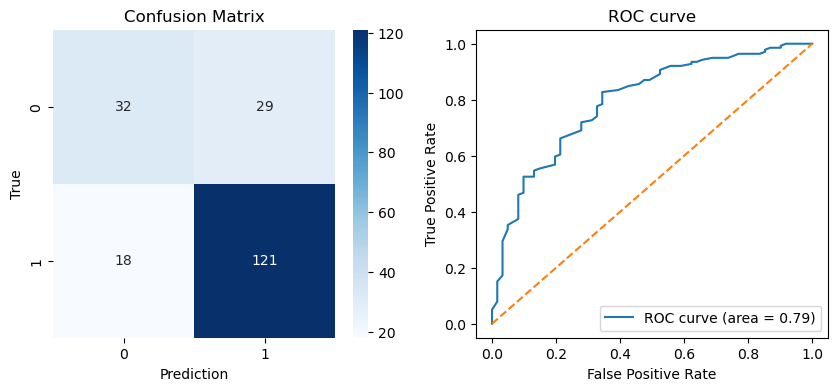

In [194]:
plot_model_performance(rf, X_test, y_test)

Accuracy: 0.795
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.64        61
           1       0.84      0.88      0.86       139

    accuracy                           0.80       200
   macro avg       0.76      0.74      0.75       200
weighted avg       0.79      0.80      0.79       200

Total Cost of Misclassification: 137


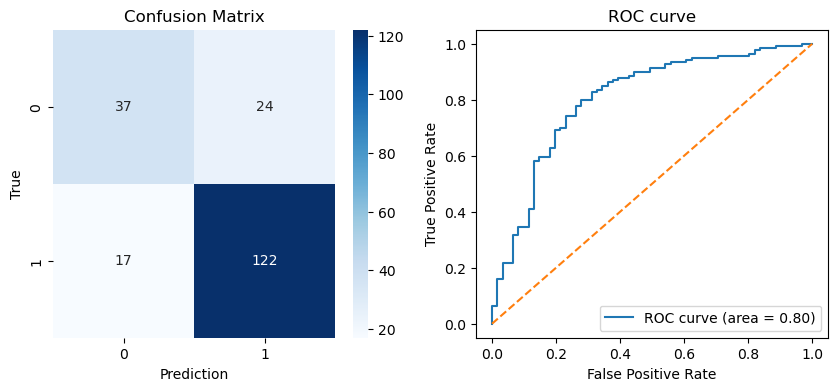

In [195]:
plot_model_performance(xgb, X_test, y_test)

### Fairness metrics

In [196]:
def classification_metrics(y_true, y_pred):
    """
    Compute classification metrics based on the confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.

    Returns:
        tuple: TPR (True Positive Rate), FPR (False Positive Rate),
            FNR (False Negative Rate), PPP (Predicted Positive Proportion)
    """
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    N = TP + FP + FN + TN # Total population
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0 # True positive rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0 # False positive rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0 # False negative rate
    PPP = (TP + FP) / N if N > 0 else 0 # Predicted as positive
    
    return TPR, FPR, FNR, PPP

In [197]:
def classification_metrics_per_group(y_true, y_pred, X_test, sens_att):
    """
    Compute classification metrics for each group defined by a sensitive attribute.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        X_test (pd.DataFrame): Test features containing the sensitive attribute.
        sens_att (str): Name of the sensitive attribute column.

    Returns:
        dict: A dictionary where each key is a group value and the value is a dictionary
            of classification metrics (TPR, FPR, FNR, PPP) for that group.
    """
    groups = X_test[sens_att]
    metrics = {}
    for group in np.unique(groups):
        group_mask = (groups == group)
        TPR, FPR, FNR, PPP = classification_metrics(y_true[group_mask], y_pred[group_mask])
        metrics[group] = {
            'TPR': TPR,
            'FPR': FPR,
            'FNR': FNR,
            'PPP': PPP
        }
    return metrics

In [198]:
def compute_fairness_metrics(model, X_test, y_true, sens_att):
    """
    Compute fairness metrics for a model based on a sensitive attribute.

    Args:
        model (object): A trained model with a predict method.
        X_test (pd.DataFrame): Test features containing the sensitive attribute.
        y_true (pd.DataFrame): True labels.
        sens_att (str): Name of the sensitive attribute column.

    Returns:
        dict: Fairness metrics including demographic parity difference, 
            equal opportunity difference, and average odds difference.
    """
    y_pred = model.predict(X_test)
    group_metrics = classification_metrics_per_group(y_true, y_pred, X_test, sens_att)
    group_0, group_1 = group_metrics[0], group_metrics[1]
    fair_metrics = {}
    fair_metrics['Demographic parity difference'] = group_0['PPP'] - group_1['PPP']
    fair_metrics['Equal opportunity difference'] = group_0['TPR'] - group_1['TPR']
    fair_metrics['Average odds difference'] = np.mean([group_0['TPR'] - group_1['TPR'], group_1['FPR'] - group_1['FPR']])
    return fair_metrics

### Reweighting

Reweighting is a bias mitigation technique introduced by Kamiran et al. (2016) that adjusts the importance of data instances based on the sensitive attribute $(S)$ and class label $(C)$. The weights for each combination of S and C are computed as :
$$w(s,c) = \frac{P_{exp}(S=s, C=c)}{P_{obs}(S=s, C=c)} = \frac{P(S=s)\cdot P(C=c)}{P(S=s, C=c)}$$
Here, $P_{obs}$ is the observed joint probability, and $P_{exp}$ assumes independance between $S$ and $C$. 

In [199]:
def reweighing(X, y, sensitive_attr):
    """
    Reweighting function to calculate instance weights based on the sensitive attribute and class labels.

    Args:
        X (pd.DataFrame): Feature DataFrame, must include the sensitive attribute column.
        y (pd.DataFrame): Labels corresponding to X.
        sensitive_attr (str): The name of the sensitive attribute column in X.

    Returns:
        pd.Series: Instance weights for each row in the dataset
    """
    # Combine X and y into a single DataFrame for easier grouping
    data = X.copy()
    data['class'] = y

    # Calculate marginal probabilities P(S=s) and P(C=c)
    p_sensitive = data[sensitive_attr].value_counts(normalize=True).to_dict()
    p_class = data['class'].value_counts(normalize=True).to_dict()

    # Calculate joint probabilities P(S=s, C=c)
    joint_counts = data.groupby([sensitive_attr, 'class']).size()
    p_joint = (joint_counts / len(data)).to_dict()

    # Calculate weights for each (S, C) pair
    weights_dict = {}
    for (s, c), p_obs in p_joint.items():
        p_exp = p_sensitive[s] * p_class[c]
        weights_dict[(s, c)] = p_exp / p_obs

    # Assign weights to each instance
    weights = data.apply(lambda row: weights_dict[(row[sensitive_attr], row['class'])], axis=1)
    
    return weights, weights_dict

In [200]:
weights, weights_dict = reweighing(X_train, y_train, 'sex')

In [201]:
weights_dict

{(0, 0): 0.8593258426966293,
 (0, 1): 1.0749700598802396,
 (1, 0): 1.0834666666666668,
 (1, 1): 0.9682233502538072}

#### Random Forest

In [202]:
rf_weight = RandomForestClassifier(random_state=42)
rf_weight.fit(X_train, y_train, sample_weight=weights)

C:\Users\lujul\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.52      0.57        61
           1       0.81      0.86      0.83       139

    accuracy                           0.76       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.75      0.76      0.75       200

Total Cost of Misclassification: 164


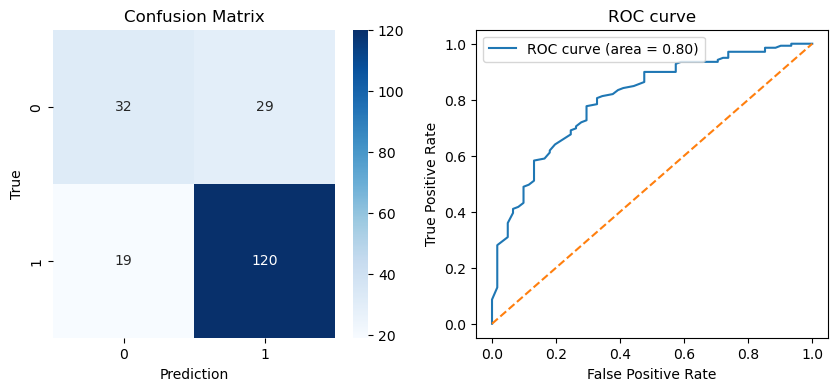

In [203]:
plot_model_performance(rf_weight, X_test, y_test)

In [204]:
print("Fairness metrics - baseline")
compute_fairness_metrics(rf, X_test, y_test, 'sex')

Fairness metrics - baseline


{'Demographic parity difference': -0.13952308472856423,
 'Equal opportunity difference': -0.1011204481792718,
 'Average odds difference': -0.0505602240896359}

In [205]:
print("Fairness metrics - reweighted")
compute_fairness_metrics(rf_weight, X_test, y_test, 'sex')

Fairness metrics - reweighted


{'Demographic parity difference': -0.10730593607305938,
 'Equal opportunity difference': -0.09159663865546219,
 'Average odds difference': -0.045798319327731096}

#### XGBoost

In [206]:
xgb_weight = XGBClassifier(random_state=42)
xgb_weight.fit(X_train, y_train, sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.57      0.60        61
           1       0.82      0.86      0.84       139

    accuracy                           0.77       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.76      0.77      0.77       200

Total Cost of Misclassification: 150


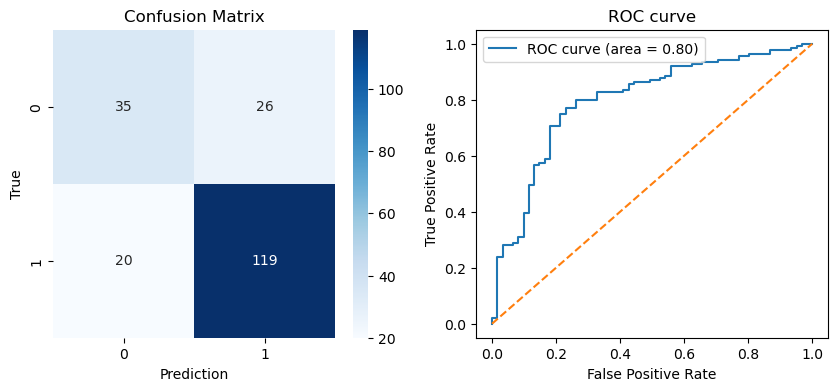

In [207]:
plot_model_performance(xgb_weight, X_test, y_test)

In [208]:
print("Fairness metrics - baseline")
compute_fairness_metrics(xgb, X_test, y_test, 'sex')

Fairness metrics - baseline


{'Demographic parity difference': -0.18822932521562663,
 'Equal opportunity difference': -0.07170868347338943,
 'Average odds difference': -0.03585434173669472}

In [209]:
print("Fairness metrics - reweighted")
compute_fairness_metrics(xgb_weight, X_test, y_test, 'sex')

Fairness metrics - reweighted


{'Demographic parity difference': -0.20674784373414512,
 'Equal opportunity difference': -0.0820728291316527,
 'Average odds difference': -0.04103641456582635}

### Logistic Regression

In [213]:
lr_weight = LogisticRegression(random_state=42)
lr_weight.fit(X_train, y_train, sample_weight=weights)

C:\Users\lujul\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

In [211]:
print("Fairness metrics - baseline")
compute_fairness_metrics(lr, X_test, y_test, 'sex')

Fairness metrics - baseline


{'Demographic parity difference': -0.12912227295788947,
 'Equal opportunity difference': -0.08123249299719892,
 'Average odds difference': -0.04061624649859946}

In [214]:
print("Fairness metrics - reweighted")
compute_fairness_metrics(lr_weight, X_test, y_test, 'sex')

Fairness metrics - reweighted


{'Demographic parity difference': 0.004566210045662156,
 'Equal opportunity difference': 0.006162464985994376,
 'Average odds difference': 0.003081232492997188}

#### Decision Tree

In [216]:
dt_weight = DecisionTreeClassifier(random_state=42)
dt_weight.fit(X_train, y_train, sample_weight=weights)

DecisionTreeClassifier(random_state=42)

In [217]:
print("Fairness metrics - baseline")
compute_fairness_metrics(dt, X_test, y_test, 'sex')

Fairness metrics - baseline


{'Demographic parity difference': -0.12912227295788947,
 'Equal opportunity difference': -0.08123249299719892,
 'Average odds difference': -0.04061624649859946}

In [218]:
print("Fairness metrics - reweighted")
compute_fairness_metrics(dt_weight, X_test, y_test, 'sex')

Fairness metrics - reweighted


{'Demographic parity difference': -0.0025367833587012223,
 'Equal opportunity difference': -0.1044817927170868,
 'Average odds difference': -0.0522408963585434}